# Modelling Bitcoin's Price with Metcalfe's Law

Modeling Bitcoin's fundemantal value with Metcalfe's law.


## Intro

According to [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) the  value of a network ([fully deluted market cap](https://capital.com/fully-diluted-market-capitalisation-in-cryptocurrency-definition)) is proportinal to the number of possible connection between their participants (wallets). As each partcipant can have $n-1$ connection, the value of the network ($V$), is 

$$ V = A \frac{n (n-1)}{2} $$

$A$, the affinity is constant, denoting the value of one (possible) conection between two network participants. 

This notebook calculates the value of Bitcoin network (V), based on the number of wallets holding at least a minimum amount of BTCs ($n_{m\leq}$). 

The straighforward and easy way of telling the value of any blockchain is to calcutate its [fully deluted market cap](https://capital.com/fully-diluted-market-capitalisation-in-cryptocurrency-definition) (FDMC). However, it has obvoius problems. FDMC is based on a highly volatile current market price, and very much subject to booms and busts of market cycles. It has no substance, and has no predictive power. The elagance of the [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) is, that once we have calibrated $A$, it can give a more grounded market value.

As $n$ is large in our case, we can shamelessly simplify our Metcalfe formula as  
$$ V = A \frac{n_{m\leq}^2}{2} $$ where 
- $V$ is the Value of the network 
- $n_{m\leq}$ denotes to the number of BTC addresses (_addressesCount_) holding at least $m$ bitcoins (as given in variable _min_btcs_ later on) and 
- $A$, is the affinity, a constant value the value of potential transaction between two wallets. An other way of putting it, for every new wallet appearing on the network with over $m$ BTCs, each wallet above $m$ BTC gains $\frac{A}{2}$ in value on average. 

As wallets can be created cheaply and algorthmically we only consider non-empty wallets. 

Our challenge is to find $A_{min}$ and $A_{max}$ values for each _min_btcs_ elements, and then to calculate the minumum and maximum BTC prices from $A_{min}$ and $A_{max}$.

$$ V_{A_{min}} \leq V_{FDMC} \leq V_{A_{max}} $$

Let $S$ be the maximum supply of of Bitcoin wich is 21 million, and $P(t)$ be the price of BTC at the time of t. As $n$ is also a function of time we can conclude that 
$$ A_{min} \frac{n_{m\leq}^2(t)}{2} \leq S P(t) \leq \frac{A_{max} n_{m\leq}^2(t)}{2} $$
$$ A_{min}  \leq \frac{2 S P(t)}{n_{m\leq}^2(t)} \leq A_{max} $$
for any $t$ point in time.

Once we calibarated the value of $A_{min}$ and $A_{max}$ for a certain $m$, we can safely assume that in any future time 

$$ 
A_{min} \leq A(t) = \frac{ 2 S P(t)}{n_{m\leq}^2(t)} \leq A_{max} 
$$


if we are more focused on minimum and maximum BTC price ranges 
$$
P_{min}(t) = A_{min} \frac{ n_{m\leq}^2(t) }{2 S}  \leq P(t) \leq P_{max}(t) = A_{max} \frac{ n_{m\leq}^2(t) }{2 S} 
$$
Later we also give try to extrapolate the growth of wallet holders, thus estimating the future price of BTC.

## Input Parameters

In [1]:
data_fetch_start_date = '2010-01-01'
plot_start_date = '2010-09-01'
k_calibration_start_date = '2017-01-01'
linear_fitting_start_date='2021-01-01'
extrapolation_end_date ='2037-06-26'

# Having more or same amount of BTC as [x,y,z]
# min_btcs =  [1000, 100, 10, 1, 0.1, 0.01, 0.001]
min_btcs = [1e-08, 0.001, 0.01, 0.1, 1, 10]

# Reuqested Simple Moving Averages for calucating A (affinity)
smas = [1,2,7,30,90,180, 365]
ranges_from_sma_days = 30

# cryptocompare.com API Key for fetching BTC wallet distributions and price
cryptocompare_api_key = '777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'
# https://data.nasdaq.com/ token to use nasdaqdatalink for M2 money supply
#nasdaqdatalink_token = 'JEn6xy3nc1JtFSLoXoVJ'
# https://fred.stlouisfed.org/
fred_api_key = 'b121cc395b21e22273f7275e8c49a2d0'


## Fetching BTC Price History


We use [CryptoCompare API](https://min-api.cryptocompare.com/documentation) to fetch the th historical BTC prices in USD, and the wallet chorots grouped by the min to max BTC ranges.

In [2]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import date
import time
requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']

limit=2000
coins=['BTC']  # Only BTC is available at cryptocompare
coin = coins[0] # 'BTC'

data_fetch_start_date_ts = pd.Timestamp(data_fetch_start_date)
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while data_fetch_start_date_ts <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            # print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
         # df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], 
                                    df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[data_fetch_start_date_ts:]
df.sort_index(inplace=True)
df

coin                    BTC                                               \
wallet_range    1e-08-0.001     0.001-0.01       0.01-0.1          0.1-1   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01                0              0              6              3   
2010-01-02                0              0              6              3   
2010-01-03                0              0              6              3   
2010-01-04                0              0              6              3   
2010-01-05                0              0              6              3   
...                     ...            ...            ...            ...   
2023-12-25         27381644       12311567        8139388        3553855   
2023-12-26         27408267       12316914        8142568        3554348   
2023-12-27         27457202       12342907        8153495        3556532   
2023-12-28         27460376       12316881        8159952        3557957   
2023-12-29         27492338       12307574        8168094        3560100   

coin                                                                      \
wallet_range           1-10         10-100       100-1000     1000-10000   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01               10          29905             26              5   
2010-01-02               10          30031             26              5   
2010-01-03               10          30217             26              5   
2010-01-04               10          30318             26              5   
2010-01-05               10          30516             26              5   
...                     ...            ...            ...            ...   
2023-12-25           867672         139472          13917           1916   
2023-12-26           867964         139358          13922           1920   
2023-12-27           868279         139475          13924           1930   
2023-12-28           868357         139425          13938           1930   
2023-12-29           868598         139436          13964           1925   

coin                                                  
wallet_range   10000-100000 100000-1000000       all  
metrics      addressesCount addressesCount     price  
time                                                  
2010-01-01                4              0      0.00  
2010-01-02                4              0      0.00  
2010-01-03                4              0      0.00  
2010-01-04                4              0      0.00  
2010-01-05                4              0      0.00  
...                     ...            ...       ...  
2023-12-25              104              4  43593.79  
2023-12-26              105              4  42517.32  
2023-12-27              104              4  43469.34  
2023-12-28              103              4  42588.94  
2023-12-29              104              4  42073.59  

[5111 rows x 11 columns]

## Wallet Range Conversion

Instead of wallet ranges bounded on both sides, we need the number wallets have a mininum number of BTCs or more, __without upper limit__. 

In [3]:
df_aux = pd.DataFrame()
aggregate_wallets=['10000-100000']

aggregate_wallets.append('1000-10000')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1000+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('100-1000')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'100+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('10-100')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'10+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('1-10')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('0.1-1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001+','addressesCount')] = df_aux['addressesCount']
#df.drop(columns=['100000-0','1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


aggregate_wallets.append('1e-08-0.001')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1e-08+','addressesCount')] = df_aux['addressesCount']


# We drop the old min-max ranges as we have now min-infinity.
df.drop(columns=['100000-1000000',*aggregate_wallets],inplace=True,level= "wallet_range")

df

coin               BTC                                               \
wallet_range       all          1000+           100+            10+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2010-01-01        0.00              9             35          29940   
2010-01-02        0.00              9             35          30066   
2010-01-03        0.00              9             35          30252   
2010-01-04        0.00              9             35          30353   
2010-01-05        0.00              9             35          30551   
...                ...            ...            ...            ...   
2023-12-25    43593.79           2020          15937         155409   
2023-12-26    42517.32           2025          15947         155305   
2023-12-27    43469.34           2034          15958         155433   
2023-12-28    42588.94           2033          15971         155396   
2023-12-29    42073.59           2029          15993         155429   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01            29950          29953          29959          29959   
2010-01-02            30076          30079          30085          30085   
2010-01-03            30262          30265          30271          30271   
2010-01-04            30363          30366          30372          30372   
2010-01-05            30561          30564          30570          30570   
...                     ...            ...            ...            ...   
2023-12-25          1023081        4576936       12716324       25027891   
2023-12-26          1023269        4577617       12720185       25037099   
2023-12-27          1023712        4580244       12733739       25076646   
2023-12-28          1023753        4581710       12741662       25058543   
2023-12-29          1024027        4584127       12752221       25059795   

coin                         
wallet_range         1e-08+  
metrics      addressesCount  
time                         
2010-01-01            29959  
2010-01-02            30085  
2010-01-03            30271  
2010-01-04            30372  
2010-01-05            30570  
...                     ...  
2023-12-25         52409535  
2023-12-26         52445366  
2023-12-27         52533848  
2023-12-28         52518919  
2023-12-29         52552133  

[5111 rows x 9 columns]

## Fetching M2 Monetary Supply

The purchasing power of $1 today is lot less then it was few years back or even a deceade ago. Therefore, we need to adjust the past BTC price to current dollar value. This happens by revaluing the original price of bitcoin so that it is proprtional to [M2 monetary supply](https://en.wikipedia.org/wiki/Money_supply) increase of US dollar. We fetch the [M2NS series](https://fred.stlouisfed.org/series/M2NS) from [FED's FRED API](https://fred.stlouisfed.org/docs/api/fred/) for the montly M2 monetary supply.

In [4]:


# https://fred.stlouisfed.org/series/M2SL
fredRequestTemplate = 'https://api.stlouisfed.org/fred/series/observations?series_id=M2NS&api_key={}&file_type=json&observation_start=2008-01-01&frequency=m'

requestUrl = fredRequestTemplate.format(fred_api_key)

#print("Request : " + requestUrl)    
response = requests.get(requestUrl).text 
parsed = json.loads(response)
#print("Json : \n\n" + response)
df_m2 = pd.DataFrame(parsed['observations'])
df_m2['date'] = pd.to_datetime(df_m2['date'], yearfirst=True,format='ISO8601')
df_m2['value'] = pd.to_numeric(df_m2['value'], errors='coerce')
df_m2.set_index(['date'],inplace=True, verify_integrity = True, drop = True)
df_m2.sort_index(inplace=True)
df_m2.drop(columns=['realtime_start','realtime_end'], inplace=True)
df_m2



,value
date,
2008-01-01,7502.6
2008-02-01,7585.2
2008-03-01,7719.2
2008-04-01,7767.6
2008-05-01,7709.1
...,...
2023-07-01,20745.3
2023-08-01,20721.2
2023-09-01,20699.7


## Adjust BTC Price with M2 Monetary Supply

In [5]:
def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    return df.loc[loc_idx,'value'].values[0] 

df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))
df

coin               BTC                                               \
wallet_range       all          1000+           100+            10+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2010-01-01        0.00              9             35          29940   
2010-01-02        0.00              9             35          30066   
2010-01-03        0.00              9             35          30252   
2010-01-04        0.00              9             35          30353   
2010-01-05        0.00              9             35          30551   
...                ...            ...            ...            ...   
2023-12-25    43593.79           2020          15937         155409   
2023-12-26    42517.32           2025          15947         155305   
2023-12-27    43469.34           2034          15958         155433   
2023-12-28    42588.94           2033          15971         155396   
2023-12-29    42073.59           2029          15993         155429   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01            29950          29953          29959          29959   
2010-01-02            30076          30079          30085          30085   
2010-01-03            30262          30265          30271          30271   
2010-01-04            30363          30366          30372          30372   
2010-01-05            30561          30564          30570          30570   
...                     ...            ...            ...            ...   
2023-12-25          1023081        4576936       12716324       25027891   
2023-12-26          1023269        4577617       12720185       25037099   
2023-12-27          1023712        4580244       12733739       25076646   
2023-12-28          1023753        4581710       12741662       25058543   
2023-12-29          1024027        4584127       12752221       25059795   

coin                              USD  
wallet_range         1e-08+       all  
metrics      addressesCount m2_supply  
time                                   
2010-01-01            29959    8464.4  
2010-01-02            30085    8464.4  
2010-01-03            30271    8464.4  
2010-01-04            30372    8464.4  
2010-01-05            30570    8464.4  
...                     ...       ...  
2023-12-25         52409535   20760.2  
2023-12-26         52445366   20760.2  
2023-12-27         52533848   20760.2  
2023-12-28         52518919   20760.2  
2023-12-29         52552133   20760.2  

[5111 rows x 10 columns]

In [6]:
btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[(coin,'all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df

coin               BTC                                               \
wallet_range       all          1000+           100+            10+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2010-01-01        0.00              9             35          29940   
2010-01-02        0.00              9             35          30066   
2010-01-03        0.00              9             35          30252   
2010-01-04        0.00              9             35          30353   
2010-01-05        0.00              9             35          30551   
...                ...            ...            ...            ...   
2023-12-25    43593.79           2020          15937         155409   
2023-12-26    42517.32           2025          15947         155305   
2023-12-27    43469.34           2034          15958         155433   
2023-12-28    42588.94           2033          15971         155396   
2023-12-29    42073.59           2029          15993         155429   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01            29950          29953          29959          29959   
2010-01-02            30076          30079          30085          30085   
2010-01-03            30262          30265          30271          30271   
2010-01-04            30363          30366          30372          30372   
2010-01-05            30561          30564          30570          30570   
...                     ...            ...            ...            ...   
2023-12-25          1023081        4576936       12716324       25027891   
2023-12-26          1023269        4577617       12720185       25037099   
2023-12-27          1023712        4580244       12733739       25076646   
2023-12-28          1023753        4581710       12741662       25058543   
2023-12-29          1024027        4584127       12752221       25059795   

coin                              USD                           BTC  
wallet_range         1e-08+       all                           all  
metrics      addressesCount m2_supply m2_supply_index  m2_adj_price  
time                                                                 
2010-01-01            29959    8464.4        1.022715      0.000000  
2010-01-02            30085    8464.4        1.022715      0.000000  
2010-01-03            30271    8464.4        1.022715      0.000000  
2010-01-04            30372    8464.4        1.022715      0.000000  
2010-01-05            30570    8464.4        1.022715      0.000000  
...                     ...       ...             ...           ...  
2023-12-25         52409535   20760.2        2.508361  17379.391507  
2023-12-26         52445366   20760.2        2.508361  16950.238786  
2023-12-27         52533848   20760.2        2.508361  17329.777438  
2023-12-28         52518919   20760.2        2.508361  16978.791294  
2023-12-29         52552133   20760.2        2.508361  16773.338420  

[5111 rows x 12 columns]

## Affinity calculation

We calcuate the M2 monetary supply-adjusted value of affinity $A_m(t)$ aka _df['BTC']['m+']['a']_ with following formula : 
$$ A_m'(t) = \frac{2 S P'(t)}{n_{m\leq}^2(t)} $$

In [7]:

btc_max_supply = 21*10**6
for min_btc in min_btcs:
    df.loc(axis=1)[(coin,str(min_btc) + '+','a')] = 2*btc_max_supply*df.loc(axis=1)[(coin,'all','m2_adj_price')] \
        / ( df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')] \
        * df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')])
    for days in smas: 
        df.loc(axis=1)[(coin, str(min_btc) + '+', 'a_sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, str(min_btc) + '+','a')].rolling(days).mean()

# df=df.loc['2013-01-01':]
df

coin               BTC                                               \
wallet_range       all          1000+           100+            10+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2010-01-01        0.00              9             35          29940   
2010-01-02        0.00              9             35          30066   
2010-01-03        0.00              9             35          30252   
2010-01-04        0.00              9             35          30353   
2010-01-05        0.00              9             35          30551   
...                ...            ...            ...            ...   
2023-12-25    43593.79           2020          15937         155409   
2023-12-26    42517.32           2025          15947         155305   
2023-12-27    43469.34           2034          15958         155433   
2023-12-28    42588.94           2033          15971         155396   
2023-12-29    42073.59           2029          15993         155429   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01            29950          29953          29959          29959   
2010-01-02            30076          30079          30085          30085   
2010-01-03            30262          30265          30271          30271   
2010-01-04            30363          30366          30372          30372   
2010-01-05            30561          30564          30570          30570   
...                     ...            ...            ...            ...   
2023-12-25          1023081        4576936       12716324       25027891   
2023-12-26          1023269        4577617       12720185       25037099   
2023-12-27          1023712        4580244       12733739       25076646   
2023-12-28          1023753        4581710       12741662       25058543   
2023-12-29          1024027        4584127       12752221       25059795   

coin                              USD  ...       BTC                       \
wallet_range         1e-08+       all  ...        1+                  10+   
metrics      addressesCount m2_supply  ... a_sma180d a_sma365d          a   
time                                   ...                                  
2010-01-01            29959    8464.4  ...       NaN       NaN   0.000000   
2010-01-02            30085    8464.4  ...       NaN       NaN   0.000000   
2010-01-03            30271    8464.4  ...       NaN       NaN   0.000000   
2010-01-04            30372    8464.4  ...       NaN       NaN   0.000000   
2010-01-05            30570    8464.4  ...       NaN       NaN   0.000000   
...                     ...       ...  ...       ...       ...        ...   
2023-12-25         52409535   20760.2  ...  0.516436  0.470168  30.222579   
2023-12-26         52445366   20760.2  ...  0.517412  0.471238  29.515778   
2023-12-27         52533848   20760.2  ...  0.518468  0.472358  30.126995   
2023-12-28         52518919   20760.2  ...  0.519435  0.473448  29.530880   
2023-12-29         52552133   20760.2  ...  0.520353  0.474511  29.161153   

coin                                                                 \
wallet_range                                                          
metrics         a_sma1d    a_sma2d    a_sma7d   a_sma30d   a_sma90d   
time                                                                  
2010-01-01     0.000000        NaN        NaN        NaN        NaN   
2010-01-02     0.000000   0.000000        NaN        NaN        NaN   
2010-01-03     0.000000   0.000000        NaN        NaN        NaN   
2010-01-04     0.000000   0.000000        NaN        NaN        NaN   
2010-01-05     0.000000   0.000000        NaN        NaN        NaN  

## Calibrating $A_{min}$ and $A_{max}$

In [8]:
ranges_from_sma_days = ranges_from_sma_days or 30

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    a_min = df[coin,wallet_range,'a_sma'+ str(ranges_from_sma_days)+ 'd'][k_calibration_start_date:].min()/btc_max_supply
    a_max = df[coin, wallet_range,'a_sma'+ str(ranges_from_sma_days)+ 'd'][k_calibration_start_date:].max()/btc_max_supply
    df.loc(axis=1)[(coin, wallet_range, 'a_min')] = a_min
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_min_price')] = \
        a_min / 2  * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_min_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    df.loc(axis=1)[(coin, wallet_range, 'a_max')] = a_max
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_max_price')] = \
        a_max / 2 * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_max_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    #print("k top-to-bottom ratio is {} at range {} using A_sma-{}d ".format(a_max/a_min,min_btc,ranges_from_sma_days ) )
    df= df.copy()


## Plot

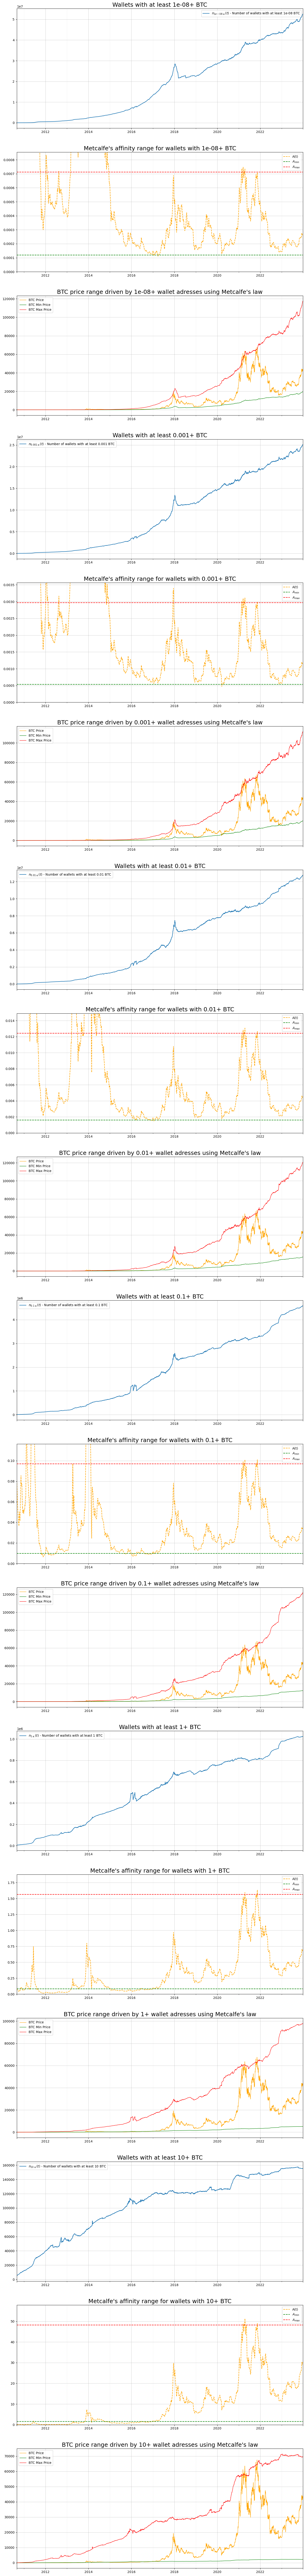

In [28]:
import matplotlib.pyplot as plt
today=df[df[coin]['all']['price'] >0 ].index.max()
subplots = len(min_btcs)*3;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

i=0
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Wallets with at least {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][str(min_btc)+'+']['addressesCount'][plot_start_date:today].plot(ax=axs[i],label='$n_{{ {} \leq}}(t) $ - Number of wallets with at least {} {}'.format(min_btc, min_btc, coin) )
    axs[i].legend(loc='best')
    axs[i].grid(axis='both', which='major', alpha=0.6)
    axs[i].grid(axis='both', which='minor', alpha=0.15)  
    
 
    axs[i+1].set_title("Metcalfe's affinity range for wallets with {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['a_sma7d'][plot_start_date:today].plot(ax=axs[i+1],color='orange',label='A(t)'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['a_min'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i+1],color='green',label='$A_{min}$', linestyle='dashed')
    (df[coin][wallet_range]['a_max'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i+1],color='red',label='$A_{max}$', linestyle='dashed')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15)
    axs[i+1].set_ylim([0,df[coin][wallet_range]['a_max'][plot_start_date:today].max()*1.2*btc_max_supply])

    axs[i+2].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    if 'm2_adj_'  == m2_adj_:
        m2_adj_text = "USD M2 Supply adjusted "
    else:
         m2_adj_text = ""
    df[coin]['all'][m2_adj_ + 'price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1, color='orange',label='{}{} Price'.format(m2_adj_text, coin))
    df[coin][wallet_range][m2_adj_ + 'bottom_price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1,color='green',label='{}{} Min Price'.format(m2_adj_text, coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1,color='red',label='{}{} Max Price'.format(m2_adj_text, coin)) 
    #axs[i+1].set_yscale('log')
    axs[i+2].legend(loc='best')
    axs[i+2].grid(which='major', alpha=0.6)
    axs[i+2].grid(which='minor', alpha=0.15)     
    i=i+3

## Extrapolation of future BTC Price Range

In [10]:
import math
import numpy as np
from datetime import date
def linear_growth(n,p_0,k):
    return k*n
def quadratic_growth(n,p_0,k):
    return k*n*n
def n_log_n_growth(n,p_0,k):
    return k*n*np.log2(n)

def limited_growth_function_log(t,p_0,k,l):
    return np.log2(l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0))
def limited_growth_function(t,p_0,k,l):
    return l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0)

from scipy.optimize import curve_fit
#p_0 = 314.25
p_0 = 4300000000.0
t_0 = pd.Timestamp('2015-01-01')
k = 7445.7718443355325
#l = 1*1000*1000*1000000

df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
    

df

coin               BTC                                               \
wallet_range       all          1000+           100+            10+   
metrics          price addressesCount addressesCount addressesCount   
time                                                                  
2010-01-01        0.00              9             35          29940   
2010-01-02        0.00              9             35          30066   
2010-01-03        0.00              9             35          30252   
2010-01-04        0.00              9             35          30353   
2010-01-05        0.00              9             35          30551   
...                ...            ...            ...            ...   
2023-12-25    43593.79           2020          15937         155409   
2023-12-26    42517.32           2025          15947         155305   
2023-12-27    43469.34           2034          15958         155433   
2023-12-28    42588.94           2033          15971         155396   
2023-12-29    42073.59           2029          15993         155429   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01            29950          29953          29959          29959   
2010-01-02            30076          30079          30085          30085   
2010-01-03            30262          30265          30271          30271   
2010-01-04            30363          30366          30372          30372   
2010-01-05            30561          30564          30570          30570   
...                     ...            ...            ...            ...   
2023-12-25          1023081        4576936       12716324       25027891   
2023-12-26          1023269        4577617       12720185       25037099   
2023-12-27          1023712        4580244       12733739       25076646   
2023-12-28          1023753        4581710       12741662       25058543   
2023-12-29          1024027        4584127       12752221       25059795   

coin                              USD  ...           BTC                   \
wallet_range         1e-08+       all  ...            1+                    
metrics      addressesCount m2_supply  ...         a_max m2_adj_max_price   
time                                   ...                                  
2010-01-01            29959    8464.4  ...  7.444887e-08        33.390412   
2010-01-02            30085    8464.4  ...  7.444887e-08        33.671950   
2010-01-03            30271    8464.4  ...  7.444887e-08        34.089715   
2010-01-04            30372    8464.4  ...  7.444887e-08        34.317645   
2010-01-05            30570    8464.4  ...  7.444887e-08        34.766682   
...                     ...       ...  ...           ...              ...   
2023-12-25         52409535   20760.2  ...  7.444887e-08     38962.620399   
2023-12-26         52445366   20760.2  ...  7.444887e-08     38976.941153   
2023-12-27         52533848   20760.2  ...  7.444887e-08     39010.696740   
2023-12-28         52518919   20760.2  ...  7.444887e-08     39013.821585   
2023-12-29         52552133   20760.2  ...  7.444887e-08     39034.707907   

coin                                                                    \
wallet_range                         10+                                 
metrics          top_price         a_min m2_adj_min_price bottom_price   
time                                                                     
2010-01-01       34.148881  7.348863e-08        32.937737    33.685924   
2010-01-02       34.436815  7.348863e-08        33.215551    33.970049   
2010-01-03       34.864070  7.348863e-08        33.627791    34.391653   
2010-01-04       35.097177  7.348863e-08        33.852707    34.621678   
2010-01-05       35.556413  7.348863e-08     

In [11]:
guess = [p_0, k]
today=df[df[coin]['all']['price'] >0 ].index.max()
min_date = df.index.min()
ix = pd.date_range(start=min_date, end=date.fromisoformat(extrapolation_end_date), freq='D')
df = df.reindex(ix)
df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
#linear_fitting_start_date='2022-01-01'
print(today)

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    parameters, covariance = curve_fit(linear_growth, df[coin]['all']['delta_days'][linear_fitting_start_date:today], df['BTC'][wallet_range]['addressesCount'][linear_fitting_start_date:today],p0=guess)
    print("p_0={}, k={}".format(parameters[0],parameters[1]))
    df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_guess')]= linear_growth((df.index-t_0).days,p_0,k)
    df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]= linear_growth((df.index-t_0).days,parameters[0],parameters[1])

    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_min_price_linear_fit')] = \
        a_min * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price_linear_fit')] = \
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_min_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   

    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_max_price_linear_fit')] = \
        a_max * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price_linear_fit')] = \
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_max_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   
    
df


2023-12-29 00:00:00
p_0=4300000000.0, k=15518.901975454544
p_0=4300000000.0, k=7573.635758740703
p_0=4300000000.0, k=3822.1496038019545
p_0=4300000000.0, k=1372.267614036964
p_0=4300000000.0, k=326.20597087687685
p_0=4300000000.0, k=54.31759080422448


/Users/szabolcsbeki/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/szabolcsbeki/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


coin           BTC                                               \
wallet_range   all          1000+           100+            10+   
metrics      price addressesCount addressesCount addressesCount   
2010-01-01     0.0            9.0           35.0        29940.0   
2010-01-02     0.0            9.0           35.0        30066.0   
2010-01-03     0.0            9.0           35.0        30252.0   
2010-01-04     0.0            9.0           35.0        30353.0   
2010-01-05     0.0            9.0           35.0        30551.0   
...            ...            ...            ...            ...   
2037-06-22     NaN            NaN            NaN            NaN   
2037-06-23     NaN            NaN            NaN            NaN   
2037-06-24     NaN            NaN            NaN            NaN   
2037-06-25     NaN            NaN            NaN            NaN   
2037-06-26     NaN            NaN            NaN            NaN   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
2010-01-01          29950.0        29953.0        29959.0        29959.0   
2010-01-02          30076.0        30079.0        30085.0        30085.0   
2010-01-03          30262.0        30265.0        30271.0        30271.0   
2010-01-04          30363.0        30366.0        30372.0        30372.0   
2010-01-05          30561.0        30564.0        30570.0        30570.0   
...                     ...            ...            ...            ...   
2037-06-22              NaN            NaN            NaN            NaN   
2037-06-23              NaN            NaN            NaN            NaN   
2037-06-24              NaN            NaN            NaN            NaN   
2037-06-25              NaN            NaN            NaN            NaN   
2037-06-26              NaN            NaN            NaN            NaN   

coin                              USD  ...                         BTC  \
wallet_range         1e-08+       all  ...                          1+   
metrics      addressesCount m2_supply  ... m2_adj_min_price_linear_fit   
2010-01-01          29959.0    8464.4  ...                26073.871171   
2010-01-02          30085.0    8464.4  ...                26045.320534   
2010-01-03          30271.0    8464.4  ...                26016.785537   
2010-01-04          30372.0    8464.4  ...                25988.266180   
2010-01-05          30570.0    8464.4  ...                25959.762463   
...                     ...       ...  ...                         ...   
2037-06-22              NaN       NaN  ...               526839.907132   
2037-06-23              NaN       NaN  ...               526968.287249   
2037-06-24              NaN       NaN  ...               527096.683005   
2037-06-25              NaN       NaN  ...               527225.094402   
2037-06-26              NaN       NaN  ...               527353.521439   

coin                                                              \
wallet_range                                                       
metrics      bottom_price_linear_fit m2_adj_max_price_linear_fit   
2010-01-01              6.540268e+04                8.148195e+05   
2010-01-02              6.533107e+04                8.139273e+05   
2010-01-03              6.525949e+04                8.130356e+05   
2010-01-04              6.518796e+04                8.121443e+05   
2010-01-05              6.511646e+04                8.112536e+05   
...                              ...                         ...   
2037-06-22              1.321505e+06                1.646397e+07   
2037-06-23              1.321827e+06                1.646798e+07   
2037-06-24              1.322149e+06                1.647200e+07   
2037-06-25              1.322471e+06                1.647601e+07   
2037-06-26              1.322793e+06                1.648002e+07   

coin  

In [12]:
#df.loc(axis=1)[('BTC_AdrBal1in10BCnt_func_unlimited')]=1000000
min_date = df.index.min()

def linear_growth_func(y_previous,a):
    return y_previous+a
def unlimited_growth_func(y_previous,r):
    return y_previous+r*y_previous
def logistic_growth_func(y_previous,r,M,m=1):
    return y_previous+y_previous*r*(1-(y_previous/M))**(1/m)

for min_btc in min_btcs:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addressesCount')][min_date]

    wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,50*1000*1000,1/4)
        df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_A')] =y
        y_prev=y
        i=i+1
for min_btc in min_btcs:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addressesCount')][min_date]

    wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,100*1000*1000,1/9)
        df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_B')] =y
        y_prev=y
        i=i+1    
for min_btc in min_btcs:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addressesCount')][min_date]

    wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,200*1000*1000,1/18)
        df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_C')] =y
        y_prev=y
        i=i+1    
df= df.copy()
df

coin           BTC                                               \
wallet_range   all          1000+           100+            10+   
metrics      price addressesCount addressesCount addressesCount   
2010-01-01     0.0            9.0           35.0        29940.0   
2010-01-02     0.0            9.0           35.0        30066.0   
2010-01-03     0.0            9.0           35.0        30252.0   
2010-01-04     0.0            9.0           35.0        30353.0   
2010-01-05     0.0            9.0           35.0        30551.0   
...            ...            ...            ...            ...   
2037-06-22     NaN            NaN            NaN            NaN   
2037-06-23     NaN            NaN            NaN            NaN   
2037-06-24     NaN            NaN            NaN            NaN   
2037-06-25     NaN            NaN            NaN            NaN   
2037-06-26     NaN            NaN            NaN            NaN   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
2010-01-01          29950.0        29953.0        29959.0        29959.0   
2010-01-02          30076.0        30079.0        30085.0        30085.0   
2010-01-03          30262.0        30265.0        30271.0        30271.0   
2010-01-04          30363.0        30366.0        30372.0        30372.0   
2010-01-05          30561.0        30564.0        30570.0        30570.0   
...                     ...            ...            ...            ...   
2037-06-22              NaN            NaN            NaN            NaN   
2037-06-23              NaN            NaN            NaN            NaN   
2037-06-24              NaN            NaN            NaN            NaN   
2037-06-25              NaN            NaN            NaN            NaN   
2037-06-26              NaN            NaN            NaN            NaN   

coin                              USD  ...                             BTC  \
wallet_range         1e-08+       all  ...                           0.01+   
metrics      addressesCount m2_supply  ... addressesCount_logistic_guess_B   
2010-01-01          29959.0    8464.4  ...                    3.002540e+04   
2010-01-02          30085.0    8464.4  ...                    3.009194e+04   
2010-01-03          30271.0    8464.4  ...                    3.015863e+04   
2010-01-04          30372.0    8464.4  ...                    3.022547e+04   
2010-01-05          30570.0    8464.4  ...                    3.029245e+04   
...                     ...       ...  ...                             ...   
2037-06-22              NaN       NaN  ...                    3.597237e+07   
2037-06-23              NaN       NaN  ...                    3.597382e+07   
2037-06-24              NaN       NaN  ...                    3.597526e+07   
2037-06-25              NaN       NaN  ...                    3.597671e+07   
2037-06-26              NaN       NaN  ...                    3.597815e+07   

coin                                                                          \
wallet_range                            0.1+                              1+   
metrics      addressesCount_logistic_guess_B addressesCount_logistic_guess_B   
2010-01-01                      3.002540e+04                    3.001938e+04   
2010-01-02                      3.009194e+04                    3.008591e+04   
2010-01-03                      3.015863e+04                    3.015259e+04   
2010-01-04                      3.022547e+04                    3.021941e+04   
2010-01-05                      3.029245e+04                    3.028639e+04   
...                                      ...                             ...   
2037-06-22                      3.597237e+07                    3.597224e+07   
2037-06-23                      3.597382e+07                    3.597369e+07   
2037-06-24             

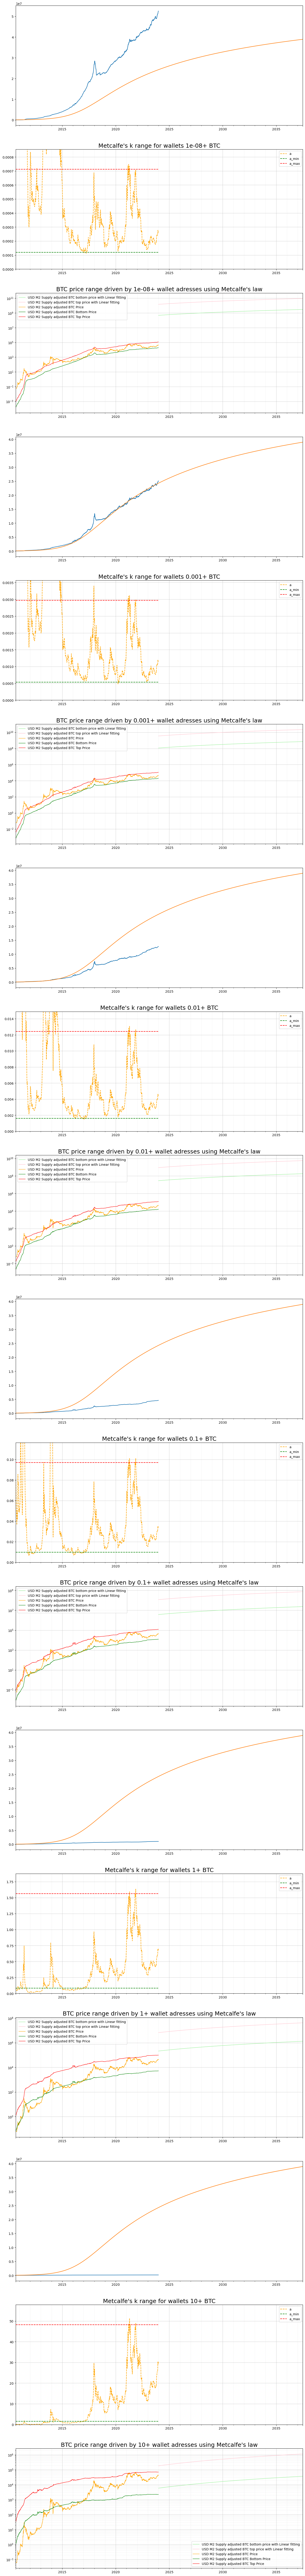

In [29]:
import matplotlib.pyplot as plt
subplots = len(min_btcs)*3;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

i=0


for min_btc in min_btcs:
    wallet_range = str(min_btc)+'+'
#    df[coin][str(min_btc)+'+']['addressesCount_linear_fit'][plot_start_date:].plot(ax=axs[0],label='Wallets over {} {} with linear curve fitting'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_linear_guess'].plot(ax=axs[0],label='Wallets over {} {} with linear guess'.format(min_btc, coin) )
    df[coin][str(min_btc)+'+']['addressesCount'][plot_start_date:today].plot(ax=axs[i],label='Wallets over {} {}'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_logistic_guess_A'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic growth A'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_logistic_guess_B'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic growth B'.format(min_btc, coin) )
    df[coin][str(min_btc)+'+']['addressesCount_logistic_guess_C'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic growth C'.format(min_btc, coin) )

    

    axs[i+1].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['a_sma7d'][plot_start_date:].plot(ax=axs[i+1],color='orange',label='a'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['a_min'][plot_start_date:]*btc_max_supply).plot(ax=axs[i+1],color='green',label='a_min', linestyle='dashed')
    (df[coin][wallet_range]['a_max'][plot_start_date:]*btc_max_supply).plot(ax=axs[i+1],color='red',label='a_max', linestyle='dashed')
    axs[i+1].legend(loc='best')
    axs[i+1].set_ylim([0,df[coin][wallet_range]['a_max'][plot_start_date:today].max()*1.2*btc_max_supply])
 
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    axs[i+2].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    wallet_range
    df[coin][wallet_range][m2_adj_ + 'bottom_price_linear_fit'][today:].plot(ax=axs[i+2], linewidth=1, color='lightgreen',label='USD M2 Supply adjusted {} bottom price with Linear fitting'.format(coin))
    df[coin][wallet_range][m2_adj_ + 'top_price_linear_fit'][today:].plot(ax=axs[i+2], linewidth=1, color='pink',label='USD M2 Supply adjusted {} top price with Linear fitting'.format(coin))

    df[coin]['all'][m2_adj_ + 'price'][plot_start_date:].plot(ax=axs[i+2], linewidth=1, color='orange',label='USD M2 Supply adjusted {} Price '.format(coin))

    df[coin][wallet_range][m2_adj_ + 'bottom_price'][plot_start_date:].plot(ax=axs[i+2], linewidth=1,color='green',label='USD M2 Supply adjusted {} Bottom Price'.format(coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][plot_start_date:].plot(ax=axs[i+2], linewidth=1,color='red',label='USD M2 Supply adjusted {} Top Price'.format(coin)) 
    axs[i+2].set_yscale('log')
    axs[i+2].legend(loc='best')
    axs[i+2].grid(which='major', alpha=0.6)
    axs[i+2].grid(which='minor', alpha=0.15) 
    i=i+3